## Import

In [1]:
%env CUDA_VISIBLE_DEVICES=2,3
!echo $CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=2,3
2,3


In [2]:
import torch

In [3]:
# DEVICE = torch.device('cpu')
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [4]:
from tqdm.notebook import tqdm

In [5]:
%run ../datasets/iu_xray.py
%run ../training/report_generation/hierarchical.py
%run ../utils/nlp.py

In [6]:
train_dataset = IUXRayDataset('train')
len(train_dataset)

5923

## Compute dataset stats

In [22]:
from collections import Counter

In [25]:
def get_dataset_stats(dataset):
    word_appearances = dict()

    words_count = []
    sentences_count = []

    for image, report in tqdm(dataset):
        # Save appearances
        for word in report:
            if word not in word_appearances:
                word_appearances[word] = 0
            word_appearances[word] += 1

        # Must end with a dot
        if report[-1] != END_OF_SENTENCE_IDX:
            report.append(END_OF_SENTENCE_IDX)

        # Count words
        n_words = len(report)
        words_count.append(n_words)

        # Count sentences
        n_sentences = report.count(END_OF_SENTENCE_IDX)
        sentences_count.append(n_sentences)

    return word_appearances, words_count, sentences_count

In [26]:
word_appearances, words_count, sentences_count = get_dataset_stats(train_dataset)

{17: 7788,
 378: 77,
 37: 1089,
 4: 27050,
 337: 143,
 362: 32,
 176: 284,
 50: 2718,
 32: 3373,
 52: 3724,
 10: 3398,
 13: 5931,
 27: 564,
 23: 4093,
 46: 1220,
 44: 586,
 14: 2485,
 8: 4642,
 11: 6869,
 299: 55,
 135: 497,
 136: 208,
 5: 10078,
 201: 539,
 16: 6950,
 26: 3651,
 53: 158,
 71: 231,
 127: 526,
 973: 1,
 922: 19,
 19: 476,
 39: 3924,
 555: 9,
 974: 1,
 523: 12,
 524: 48,
 1290: 2,
 30: 593,
 62: 2341,
 878: 5,
 181: 770,
 285: 209,
 283: 79,
 930: 52,
 217: 249,
 661: 35,
 265: 277,
 29: 1260,
 123: 834,
 28: 3850,
 22: 4174,
 219: 127,
 349: 66,
 359: 59,
 395: 61,
 51: 216,
 9: 934,
 49: 241,
 35: 697,
 25: 4005,
 55: 491,
 76: 27,
 77: 35,
 63: 1450,
 78: 7,
 45: 1164,
 165: 404,
 166: 343,
 20: 2767,
 225: 197,
 206: 7,
 43: 1673,
 449: 37,
 158: 171,
 164: 944,
 113: 213,
 718: 20,
 112: 475,
 226: 161,
 131: 354,
 107: 317,
 450: 117,
 139: 871,
 109: 942,
 730: 19,
 568: 39,
 533: 42,
 341: 119,
 258: 174,
 363: 117,
 260: 77,
 284: 388,
 41: 706,
 228: 270,
 292:

In [67]:
import matplotlib.pyplot as plt
import numpy as np

In [65]:
def plot_counter(counter, title):
    x = list(counter.keys())
    y = list(counter.values())
    
    plt.bar(x, y)
    plt.title(title)

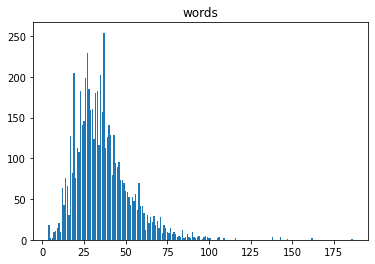

In [66]:
plot_counter(Counter(words_count), 'words')

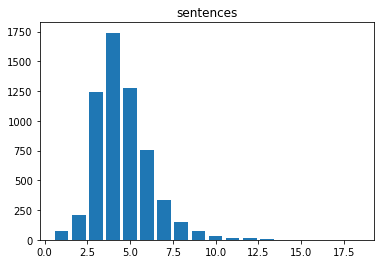

In [70]:
plot_counter(Counter(sentences_count), 'sentences')

In [77]:
counter = Counter(sentences_count)

In [94]:
def get_percentiles(counter):
    items = sorted(counter.items())

    keys, values = zip(*items)

    return list(zip(keys, np.cumsum(values) / total * 100))

In [95]:
get_percentiles(Counter(words_count))

[(4, 0.30390005065000847),
 (5, 0.3376667229444538),
 (6, 0.37143339523889923),
 (7, 0.5402667567111261),
 (8, 0.7259834543305757),
 (9, 0.9792334965389161),
 (10, 1.3169002194833699),
 (11, 1.485733580955597),
 (12, 2.566267094377849),
 (13, 3.2922505487084246),
 (14, 4.575384095897349),
 (15, 5.689684281614047),
 (16, 6.196184366030728),
 (17, 8.340368056728009),
 (18, 9.724801620800271),
 (19, 13.169002194833698),
 (20, 14.452135742022623),
 (21, 16.35995272665879),
 (22, 18.183353030558838),
 (23, 21.27300354550059),
 (24, 23.65355394225899),
 (25, 26.118521019753505),
 (26, 29.461421576903597),
 (27, 33.327705554617594),
 (28, 36.451122741853794),
 (29, 39.135573189262196),
 (30, 41.83690697281783),
 (31, 43.93044065507345),
 (32, 46.96944116157353),
 (33, 50.05909167651528),
 (34, 52.017558669593114),
 (35, 55.4279925713321),
 (36, 58.07867634644606),
 (37, 62.367043727840624),
 (38, 64.25797737632956),
 (39, 66.38527773087962),
 (40, 68.76582812763802),
 (41, 70.94377849062975),

In [96]:
get_percentiles(Counter(sentences_count))

[(1, 1.2324835387472564),
 (2, 4.761100793516799),
 (3, 25.730204288367382),
 (4, 55.10720918453487),
 (5, 76.66722944453824),
 (6, 89.39726489954415),
 (7, 95.03629917271653),
 (8, 97.6194496032416),
 (9, 98.86881647813608),
 (10, 99.42596657099443),
 (11, 99.71298328549722),
 (12, 99.89869998311667),
 (13, 99.96623332770555),
 (17, 99.98311666385278),
 (18, 100.0)]

## Evaluate models in subsets

In [7]:
%run -n train_report_generation.py
%run datasets/__init__.py
%run models/checkpoint/__init__.py
%run training/report_generation/flat.py
%run training/report_generation/hierarchical.py
%run models/report_generation/__init__.py

In [8]:
def eval_in_subset(run_name, compiled_model, debug=True, max_n_words=None, max_n_sentences=None,
                   device='cuda'):
    # Create datasets
    vocab = compiled_model.metadata['vocab']
    train_dataset = IUXRayDataset('train', vocab=vocab)
    val_dataset = IUXRayDataset('val', vocab=vocab)
    test_dataset = IUXRayDataset('test', vocab=vocab)
    
    # Prepare subsets
    subset_kwargs = {
        'max_n_words': max_n_words,
        'max_n_sentences': max_n_sentences,
    }
    
    train_subset = create_report_dataset_subset(train_dataset, **subset_kwargs)
    val_subset = create_report_dataset_subset(val_dataset, **subset_kwargs)
    test_subset = create_report_dataset_subset(test_dataset, **subset_kwargs)
    
    # Decide hierachical
    decoder_name = compiled_model.metadata['decoder_kwargs']['decoder_name']
    hierarchical = is_decoder_hierarchical(decoder_name)
    if hierarchical:
        create_dataloader = create_hierarchical_dataloader
    else:
        create_dataloader = create_flat_dataloader

    # Create dataloaders
    BS = 50
    train_dataloader = create_dataloader(train_subset, batch_size=BS)
    val_dataloader = create_dataloader(val_subset, batch_size=BS)
    test_dataloader = create_dataloader(test_subset, batch_size=BS)
    
    # Create a suffix
    if max_n_words:
        suffix = f'max-words-{max_n_words}'
    elif max_n_sentences:
        suffix = f'max-sentences-{max_n_sentences}'
        
    evaluate_and_save(run_name,
                      compiled_model.model,
                      train_dataloader,
                      val_dataloader,
                      test_dataloader,
                      hierarchical=hierarchical,
                      debug=debug,
                      device=device,
                      suffix=suffix,
                     )

In [13]:
eval_n_words = [
    20 , # --> 15%
    25 , # --> 26%
    27 , # --> 33%
    33 , # --> 50%
#     39 , # --> 66%
#     41 , # --> 70%
    44 , # --> 75%
#     47 , # --> 80%
#     58 , # --> 90%
    # None, # --> 100%
]

In [14]:
eval_n_sentences = [
#     1, # 1.2324835387472564
#     2, # 4.761100793516799
    3, # 25.730204288367382
    4, # 55.10720918453487
    5, # 76.66722944453824
    6, # 89.39726489954415
#     7, # 95.03629917271653
#     8, # 97.6194496032416
#     9, # 98.86881647813608
#     10, # 99.42596657099443
#     11, # 99.71298328549722
#     12, # 99.89869998311667
#     13, # 99.96623332770555
#     17, # 99.98311666385278
#     18, # 100
]

In [15]:
run_names = [
#     '0717_041434_lstm_lr0.0001_densenet-121',
    '0716_211601_lstm-att_lr0.0001_densenet-121', # faltan 33 y 34
#     '0717_015057_h-lstm_lr0.0001_densenet-121',
#     '0716_234501_h-lstm-att_lr0.0001_densenet-121',
]
debug = False

In [16]:
for run_name in run_names:
    compiled_model = load_compiled_model_report_generation(run_name,
                                                           debug=debug,
                                                           multiple_gpu=True,
                                                           device=DEVICE)
    for n_words in tqdm(eval_n_words):
        eval_in_subset(run_name,
                       compiled_model,
                       max_n_words=n_words,
                       max_n_sentences=None,
                       debug=debug,
                       device=DEVICE,
                      )
    for n_sentences in tqdm(eval_n_sentences):
        eval_in_subset(run_name,
                       compiled_model,
                       max_n_words=None,
                       max_n_sentences=n_sentences,
                       debug=debug,
                       device=DEVICE,
                      )

Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-words-33.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-words-44.json



Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-3.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-4.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-5.json
Evaluating model in train...
Evaluating model in val...
Evaluating model in test...
Saved metrics to /mnt/workspace/medical-report-generation/report_generation/results/0716_211601_lstm-att_lr0.0001_densenet-121/metrics-max-sentences-6.json



## Eval H-LSTM outputs

### Load model

In [7]:
%run ../models/report_generation/__init__.py
%run ../models/checkpoint/__init__.py

In [8]:
# run_name = '0716_234501_h-lstm-att_lr0.0001_densenet-121'
# run_name = '0717_015057_h-lstm_lr0.0001_densenet-121'
# run_name = '0720_192858_lstm_lr0.0001_densenet-121_size256'
# run_name = '0717_041434_lstm_lr0.0001_densenet-121'
run_name = '0716_211601_lstm-att_lr0.0001_densenet-121'
debug = False

In [9]:
compiled_model = load_compiled_model_report_generation(run_name,
                                                       debug=debug,
                                                       device=DEVICE,
                                                      )

_ = compiled_model.model.eval()

In [10]:
compiled_model.metadata['decoder_kwargs']

{'decoder_name': 'lstm-att',
 'vocab_size': 1775,
 'embedding_size': 100,
 'hidden_size': 100,
 'features_size': [1024, 16, 16],
 'teacher_forcing': True}

In [11]:
VOCAB = compiled_model.metadata['vocab']
len(VOCAB)

1775

### Load data

In [12]:
%run ../datasets/iu_xray.py

In [13]:
dataset_kwargs = {
    'max_samples': None,
    'frontal_only': False,
    'image_size': (512, 512),
    'vocab': VOCAB,
}

train_dataset = IUXRayDataset(dataset_type='train', **dataset_kwargs)
val_dataset = IUXRayDataset(dataset_type='val', **dataset_kwargs)
test_dataset = IUXRayDataset(dataset_type='test', **dataset_kwargs)
len(train_dataset), len(val_dataset), len(test_dataset)

(5923, 751, 752)

### Eval

In [14]:
from ignite.engine import Engine, Events

In [23]:
%run ../training/report_generation/hierarchical.py
%run ../training/report_generation/flat.py
%run ../utils/nlp.py
%run ../utils/__init__.py
%run ../metrics/report_generation/__init__.py

In [16]:
is_hierarchical = compiled_model.metadata['decoder_kwargs']['decoder_name'].startswith('h-')

if is_hierarchical:
    get_step_fn = get_step_fn_hierarchical
    create_dataloader = create_hierarchical_dataloader
else:
    get_step_fn = get_step_fn_flat
    create_dataloader = create_flat_dataloader

In [17]:
dataloader = create_dataloader(test_dataset, batch_size=1)

In [18]:
free = True

In [24]:
tester = Engine(get_step_fn(compiled_model.model, training=False, free=free, device=DEVICE))
attach_metrics_report_generation(tester, hierarchical=is_hierarchical, free=free)
attach_report_writer(tester, VOCAB, run_name, debug=True)

In [29]:
tester.state.dataloader.dataset.dataset_type

'test'

In [25]:
tester.run(dataloader, 1)

State:
	iteration: 752
	epoch: 1
	epoch_length: 752
	max_epochs: 1
	output: <class 'dict'>
	batch: <class 'medai.datasets.common.BatchItems'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [33]:
tester.state.metrics

{'loss': -1.0,
 'bleu1': 0.2274829111379126,
 'bleu2': 0.14307057645948942,
 'bleu3': 0.09893463044593184,
 'bleu4': 0.0713106247352369,
 'bleu': 0.1351996856946427,
 'rougeL': 0.27017315624793853,
 'ciderD': 0.10152144255592997}

In [24]:
def eval_sample(compiled_model, image, report,
                show=True, device=DEVICE, free=False, **kwargs):
    report_reader = ReportReader(compiled_model.metadata['vocab'])
    
    is_hierarchical = compiled_model.metadata['decoder_kwargs']['decoder_name'].startswith('h-')
    
    # Prepare inputs
    images = image.unsqueeze(0).to(device)
    if is_hierarchical:
        reports = split_sentences_and_pad(report)
    else:
        reports = torch.tensor(report)

    reports = reports.unsqueeze(0).to(device)
    
    # Pass thru model
    if not is_hierarchical:
        del kwargs['max_sentences']
    tup = compiled_model.model(images, reports, free=free, **kwargs)
    
    # Parse outputs
    if is_hierarchical:
        generated = _flatten_gen_reports(tup[0], tup[1])
    else:
        generated = tup[0]
        _, generated = generated.max(dim=-1)

    generated = generated.squeeze(0).cpu()
    
    # Print result
    original_report = report_reader.idx_to_text(report)
    generated_report = report_reader.idx_to_text(generated)
    if show:
        print(original_report)
        print('-'*20)
        print(generated_report)
        
    return original_report, generated_report

In [31]:
idx = 200

image, report = train_dataset[idx]

gt, gen = eval_sample(compiled_model, image, report,
                      free=True, max_sentences=100, max_words=100)

heart normal . lungs clear . calcified left lower lobe 5 mm granuloma
--------------------
heart normal . lungs clear . no pneumothorax or pleural effusion . END


### Eval metrics on dataset

#### BLEU

In [32]:
from pycocoevalcap.bleu import bleu_scorer

In [33]:
s = bleu_scorer.BleuScorer(n=4)
s += (gen, [gt])
scores_avg, scores_all = s.compute_score()
scores_avg, len(scores_all[0])

([0.46153846146745575,
  0.43852900958464325,
  0.4119912452509562,
  0.38058030010480765],
 1)

In [40]:
def eval_dataset(dataset, max_samples=None, free=False):
    scorer = bleu_scorer.BleuScorer(n=4)
    report_lens = []
    
    n_samples = len(dataset) if max_samples is None else max_samples
    for idx in tqdm(range(n_samples)):
        image, report = dataset[idx]

        report_lens.append(len(report))

        gt, gen = eval_sample(compiled_model, image, report, show=False,
                              free=free, max_sentences=100, max_words=20)

        scorer += (gen, [gt])
    scores_avg, scores_all = scorer.compute_score()
    scores_all = np.array(scores_all)

    return scores_avg, scores_all, report_lens

In [269]:
train_results = eval_dataset(train_dataset, free=True)
train_results[0]

[0.16835218251085712,
 0.10554277592636395,
 0.07296819313164568,
 0.05292745343539316]

In [270]:
val_results = eval_dataset(val_dataset, free=True)
val_results[0]

[0.1776066165498987,
 0.10954749616009493,
 0.07444893364873906,
 0.05321739026241552]

In [35]:
test_results = eval_dataset(test_dataset, free=True)
test_results[0]

[0.2359481128077447,
 0.1516891752655873,
 0.10404271781894223,
 0.07447624964919011]

#### Rouge-L

In [36]:
from pycocoevalcap.rouge import rouge

In [50]:
idx = 800

image, report = train_dataset[idx]

gt, gen = eval_sample(compiled_model, image, report,
                      free=True, max_sentences=100, max_words=100)

scorer = rouge.Rouge()
scorer.calc_score([gen], [gt])

stable heart size . diffuse bilateral interstitial opacities . no pneumothorax . no effusions . no acute bony abnormalities .
--------------------
stable cardiomediastinal silhouette . no focal consolidation , pleural effusion , or pneumothorax . no acute bony abnormality . END


0.45

In [55]:
def eval_dataset(dataset, max_samples=None, free=False):
    scorer = rouge.Rouge()
    scores = []
    report_lens = []
    
    n_samples = len(dataset) if max_samples is None else max_samples
    for idx in tqdm(range(n_samples)):
        image, report = dataset[idx]

        report_lens.append(len(report))

        gt, gen = eval_sample(compiled_model, image, report, show=False,
                              free=free, max_sentences=100, max_words=20)

        scores.append(scorer.calc_score([gen], [gt]))

    return np.mean(scores), np.array(scores), report_lens

In [42]:
test_results = eval_dataset(test_dataset, free=True)
test_results[0]

0.3080028564452431

#### CIDEr

In [77]:
from pycocoevalcap.cider import cider_scorer

In [80]:
idx = 800
image, report = train_dataset[idx]

gt, gen = eval_sample(compiled_model, image, report,
                      free=True, max_sentences=100, max_words=100)

scorer = cider_scorer.CiderScorer(n=4)
scorer += (gen, [gt])

idx = 0
image, report = train_dataset[idx]

gt, gen = eval_sample(compiled_model, image, report,
                      free=True, max_sentences=100, max_words=100)
scorer += (gen, [gt])

scorer.compute_score()

stable heart size . diffuse bilateral interstitial opacities . no pneumothorax . no effusions . no acute bony abnormalities .
--------------------
stable cardiomediastinal silhouette . no focal consolidation , pleural effusion , or pneumothorax . no acute bony abnormality . END
no active disease .
--------------------
no focal consolidation . no pneumothorax . no pleural effusion seen . END


(1.1229230191360247, array([2.24584604, 0.        ]))

In [81]:
def eval_dataset(dataset, max_samples=None, free=False):
    scorer = cider_scorer.CiderScorer(n=4)
    report_lens = []
    
    n_samples = len(dataset) if max_samples is None else max_samples
    for idx in tqdm(range(n_samples)):
        image, report = dataset[idx]

        report_lens.append(len(report))

        gt, gen = eval_sample(compiled_model, image, report, show=False,
                              free=free, max_sentences=100, max_words=20)

        scorer += (gen, [gt])
    scores_avg, scores_all = scorer.compute_score()
    scores_all = np.array(scores_all)

    return scores_avg, scores_all, report_lens

In [85]:
val_results = eval_dataset(val_dataset, free=False)
val_results[0]

0.2953398082049025

In [83]:
test_results = eval_dataset(test_dataset, free=False)
test_results[0]

0.21860380772512616

#### Plots

In [51]:
import matplotlib.pyplot as plt

In [58]:
results = test_results

In [59]:
all_scores = results[1]
# all_scores = all_scores.mean(axis=0)
# all_scores = all_scores[0, :]
all_scores.shape

(752,)

In [60]:
lens = np.array(results[2])
lens.shape

(752,)

###### Plot scatter

Text(0, 0.5, 'Metric')

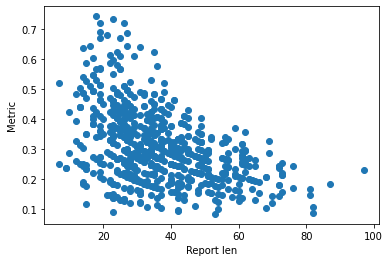

In [63]:
plt.scatter(lens, all_scores)
plt.xlabel('Report len')
plt.ylabel('Metric')

###### Adjust linear regression

In [241]:
from sklearn.linear_model import LinearRegression as LR

In [253]:
lr = LR()
lr.fit(lens.reshape(-1, 1), all_scores)

LinearRegression()

In [254]:
lr.coef_, lr.intercept_

(array([0.00207335]), 0.1493450188187051)

###### Plot hist

Text(0, 0.5, 'Occurences')

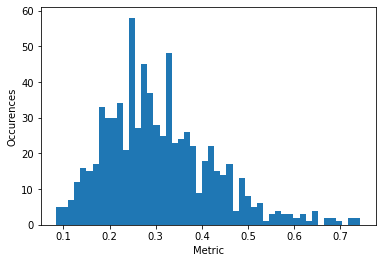

In [64]:
plt.hist(all_scores, bins=50)
plt.xlabel('Metric')
plt.ylabel('Occurences')

In [66]:
results[0]

0.3080028564452431

In [65]:
results[1].mean(axis=0).shape

()

#### Eval sample with ordered scores

In [67]:
results = test_results
dataset = test_dataset

In [69]:
scores_all = results[1]
# BLEU
# ordered_values = [
#     (i, *scores_all[:, i]) 
#     for i in range(scores_all.shape[1])
# ]
ordered_values = list(enumerate(scores_all)) # ROUGE-L, CIDEr
len(ordered_values)

752

In [70]:
ordered_values = sorted(ordered_values, key=lambda x:x[1], reverse=True)

In [76]:
idx, *scores = ordered_values[2]

print(scores)
image, report = dataset[idx]

gt, gen = eval_sample(compiled_model, image, report,
                      free=True, max_sentences=100, max_words=100)

[0.7221448467966572]
the heart is normal in size and contour . the lungs are clear , without evidence of infiltrate . there is no pneumothorax or effusion .
--------------------
the heart size is normal . the lungs are clear . there is no pneumothorax or pleural effusion . END


## Debug metrics

### Distinct words

In [110]:
%run ../metrics/report_generation/distinct_words.py

In [111]:
dw = DistinctWords()
dw.reset()

In [112]:
reports = torch.tensor([[1, 2, 3, 4],
                        [21, 12, 1, 0],
                       ])

In [113]:
reports2 = reports + 1
reports2

tensor([[ 2,  3,  4,  5],
        [22, 13,  2,  1]])

In [114]:
dw.update(reports)
dw.update(reports2)
dw.compute()

9

In [115]:
dw.words_seen

Counter({1: 3, 2: 3, 3: 2, 4: 2, 21: 1, 12: 1, 5: 1, 22: 1, 13: 1})

### Distinct sentences

In [120]:
%run ../metrics/report_generation/distinct_sentences.py

In [127]:
ds = DistinctSentences()
ds.reset()

In [128]:
reports = torch.tensor([
    [[11, 21, 37, 4],
     [29, 32, 52, 4],
    ],
    [[11, 21, 37, 4],
     [29, 32, 52, 4],
    ],
    [[12, 23, 47, 4],
     [30, 33, 53, 5],
    ],
])

In [129]:
ds.update(reports)
ds.update(reports + 1)
ds.compute()

7

In [130]:
ds.sentences_seen

Counter({'11 21 37 4': 2,
         '29 32 52 4': 2,
         '12 23 47 4': 1,
         '30 33 53 5': 3,
         '12 22 38 5': 2,
         '13 24 48 5': 1,
         '31 34 54 6': 1})

## Debug others

In [2]:
from sklearn.metrics import roc_auc_score
import numpy as np

In [3]:
a = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 1, 1],
             ])
b = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 1, 1],
             ])

In [5]:
roc_auc_score(a, b, average=None)

array([1., 1., 1.])

In [6]:
import hashlib

In [42]:
%run -n ../eval_report_generation_chexpert_labeler.py

In [43]:
run_name = '0915_172446_dummy-common-sentences-100'

In [45]:
evaluate_run(run_name, debug=True, max_samples=30, override=True)

Using cached labels for ground truth
Labelling generated...
Only one class present in y_true. ROC AUC score is not defined in that case.
Saved to file:  /mnt/workspace/medical-ai/report_generation/results/debug/0915_172446_dummy-common-sentences-100/chexpert-metrics-notfree.json
{'train': {'f1': 0.06493506493506493,
           'f1-Atelectasis': 0.0,
           'f1-Cardiomegaly': 0.0,
           'f1-Consolidation': 0.0,
           'f1-Edema': 0.0,
           'f1-Enlarged Cardiomediastinum': 0.0,
           'f1-Fracture': 0.0,
           'f1-Lung Lesion': 0.0,
           'f1-Lung Opacity': 0.0,
           'f1-No Finding': 0.9090909090909091,
           'f1-Pleural Effusion': 0.0,
           'f1-Pleural Other': 0.0,
           'f1-Pneumonia': 0.0,
           'f1-Pneumothorax': 0.0,
           'f1-Support Devices': 0.0,
           'prec': 0.06613756613756613,
           'prec-Atelectasis': 0.0,
           'prec-Cardiomegaly': 0.0,
           'prec-Consolidation': 0.0,
           'prec-Edem